# Computer Vision and Deep Learning - Laboratory 4
 
The main objective of this laboratory is to familiarize you with the training process of a neural network. More specifically, you'll follow this ["recipe"](!http://karpathy.github.io/2019/04/25/recipe/) for training  neural networks proposed by Andrew Karpathy.
You'll go through all the steps of training, data preparation, debugging, hyper-parameter tuning.
 
In the second part of the laboratory, you'll experiment with _transfer learning_ and _fine-tuning_.  Transfer learning is a concept from machine learning which allows you to reuse the knowledge gained while solving a problem (in our case the CNN weights) and applying it to solve a similar problem. This is useful when you are facing a classification problem with a small training dataset.


In [7]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2

# Data loading. Training a neural network. Tuning hyper-parameters. 

Your task for the first part of the laboratory is to train a convolutional nerual network for image classification. You can choose any dataset for image classification. By default you can use the [Oxford Pets dataset](!https://www.robots.ox.ac.uk/~vgg/data/pets/), but you can choose a dataset that you will be using for your project or an interesting dataset from [Kaggle](!https://www.kaggle.com/datasets?search=image).

So the first step would be download your training data.

In [2]:
!wget https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz # replace it with the link to the dataset that you will be using
!wget https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz 

!tar -xvf images.tar.gz
!tar -xvf annotations.tar.gz 

--2022-01-05 15:48:25--  https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 791918971 (755M) [application/x-gzip]
Saving to: ‘images.tar.gz’

images.tar.gz       100%[===================>] 755,23M  25,8MB/s    in 30s     

2022-01-05 15:48:58 (24,9 MB/s) - ‘images.tar.gz’ saved [791918971/791918971]

--2022-01-05 15:48:59--  https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19173078 (18M) [application/x-gzip]
Saving to: ‘annotations.tar.gz’

annotations.tar.gz  100%[===================>]  18,28M  18,4MB/s    in 1,0s    

2022-01-05 15:49:00 (18,4 M

In [19]:
def resize_image(image, width = None, height = None, inter = cv2.INTER_AREA):
    # initialize the dimensions of the image to be resized and
    # grab the image size
    dim = None
    (h, w) = image.shape[:2]

    # if both the width and height are None, then return the
    # original image
    if width is None and height is None:
        return image

    # check to see if the width is None
    if width is None:
        # calculate the ratio of the height and construct the
        # dimensions
        r = height / float(h)
        dim = (int(w * r), height)

    else:
        # calculate the ratio of the width and construct the
        # dimensions
        if w > h:
            r = width / float(w)
            dim = (width, int(h * r))
        else: 
            r = height / float(h)
            dim = (int(w * r), height)

    # resize the image
    resized = cv2.resize(image, dim, interpolation = inter)

    # return the resized image
    return resized

In [17]:
def process_image(path):
    image = cv2.imread(path)
    if image is None:
        return
    image = resize_image(image, 32, 32)
    top = bottom = (32 - image.shape[0]) // 2
    left = right = (32 - image.shape[1]) // 2
    bottom = bottom + 1 if top + bottom + image.shape[0] < 32  else bottom
    right = right + 1 if left + right + image.shape[1] < 32 else right
    image = cv2.copyMakeBorder(image, top,bottom,left,right, cv2.BORDER_REPLICATE)
    return image

## Data loading 
 
Up until now, we could load the data to train our model in a single line of code: we just used numpy.load to read the entire training and test sets into memory.
However, in some cases we won't be able to fit all the data into the memory due to hardware constraints.
 
To alleviate this problem, we'll use the [_Sequence_](!https://www.tensorflow.org/api_docs/python/tf/keras/utils/Sequence) class from tensorflow which allows us to feed data to our models.
To write a custom data generator, you'll have to 
- write a class that inherits from the class _Sequence_
- override the \_\_len\_\_ method: this method should return the number of batches in a sequence. In this method you can just return the value:
\begin{equation}
len = \frac{training\_samples}{batch\_size}
\end{equation}
- override the \_\_get_item\_\_(self, index) method: this should return a complete batch;
- optionally, you can override other methods, such as on_epoch_end(). For example, here you could shuffle the data after each epoch.
 
What's nice about this is that when calling the fit() method on a model with a _Sequence_, you can set the use_multiprocessing to True and use several workers that will generate the training batches in parallel.
 
``
fit(
    x=None, y=None, batch_size=None, epochs=1, verbose='auto',
    callbacks=None, validation_split=0.0, validation_data=None, shuffle=True,
    class_weight=None, sample_weight=None, initial_epoch=0, steps_per_epoch=None,
    validation_steps=None, validation_batch_size=None, validation_freq=1,
    max_queue_size=10, workers=1, use_multiprocessing=False
)
``
 
Start by writing a custom data generator for the dataset that you chose.



In [15]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, db_dir, batch_size, input_shape, num_classes, 
                 shuffle=True):
        # TODO your initialization
        # you might want to store the parameters into class variables
        self.input_shape = input_shape
        self.batch_size = batch_size
        self.num_classes = num_classes
        self.shuffle = shuffle
        self.db_dir = db_dir
        # load the data from the root directory
        self.data, self.labels = self.get_data(db_dir)
        self.indices = np.arange(len(self.data))
        self.on_epoch_end()

    def get_data(self, root_dir):
        """
        Loads the paths to the images and their corresponding labels from the database directory
        """
        # TODO your code here
        self.data = []
        self.labels = []
        with open('labels.txt', 'r') as f:
            for line in f.readlines():
                splitted = line.split()
                self.data.append("./{0}/".format(root_dir) + splitted[0] + ".jpg")
                self.labels.append(int(splitted[1]))
        return self.data, self.labels

    def __len__(self):
        """
        Returns the number of batches per epoch: the total size of the dataset divided by the batch size
        """
        return int(np.floor(len(self.data) / self.batch_size))
       
        

    def __getitem__(self, index):
        """
        Generates a batch of data
        """
        batch_indices = self.indices[index*self.batch_size : (index+1)*self.batch_size]
        for index in batch_indices:
            img = cv2.imread(self.data[index])
            dimensions = img.shape
        batch_x = [cv2.cvtColor(process_image(self.data[index]), cv2.COLOR_BGR2RGB) for index in batch_indices] # TODO load the image from batch_indices
        batch_y = [self.labels[index] - 1 for index in batch_indices] # TODO load the corresponding labels of the images you loaded
        # optionally you can use: batch_y = tf.keras.utils.to_categorical(batch_y, num_classes=self.num_classes)
        return np.array(batch_x), np.array(batch_y)

    def on_epoch_end(self):
        """
        Called at the end of each epoch
        """
        # if required, shuffle your data after each epoch
        self.indices = np.arange(len(self.data))
        if self.shuffle:
            # TODO shuffle data
            # you might find np.random.shuffle useful here
            np.random.shuffle(self.indices)


Now let's look at some images and samples from our data generator.

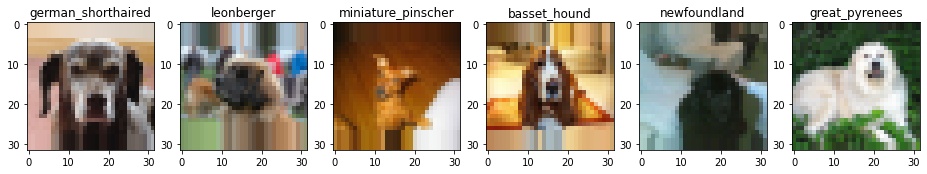

In [48]:
label_names = [None for _ in range(38)]
with open('labels.txt', 'r') as f:
    for line in f.readlines():
        splitted = line.split()
        label_idx = int(splitted[1])
        label_names[label_idx] = splitted[0][0: splitted[0].rindex('_')]
            

train_generator = DataGenerator( db_dir = "./images", input_shape = (32, 32, 3), num_classes = 37, #TODO other params
    batch_size=32, shuffle=True)

batch_x, batch_y = train_generator[0]

fig, axes = plt.subplots(nrows=1, ncols=6, figsize=[16, 9])
for i in range(len(axes)):
    axes[i].set_title(label_names[batch_y[i] + 1])
    axes[i].imshow(batch_x[i])
plt.show()


# CNN architecture

Write a simple tensorflow architecture for a convolutional neural network.
Use the [functional](!https://www.tensorflow.org/guide/keras/functional) api when writing the model.


In [2]:
from tensorflow.keras.layers import *
from tensorflow.keras.initializers import he_normal
from tensorflow.keras.activations import softmax

In [4]:
def res_block(inputs, filters):
    x = Conv2D(filters, 3, padding='same', activation='relu', kernel_initializer = he_normal())(inputs)
    x = Conv2D(filters, 3, padding='same', activation='relu', kernel_initializer = he_normal())(x)
    return x + inputs

In [10]:
inputs = Input(shape=(32, 32, 3))
print(inputs.shape)
x = Conv2D(32, 3, padding='same', activation='relu', kernel_initializer = he_normal())(inputs)
x = res_block(x, 32)
x = MaxPooling2D()(x)
x = Conv2D(64, 3, padding='same', activation='relu', kernel_initializer = he_normal())(x)
x = res_block(x, 64)
x = MaxPooling2D()(x)
x = Conv2D(128, 3, padding='same', activation='relu', kernel_initializer = he_normal())(x)
x = res_block(x, 128)
x = GlobalAveragePooling2D()(x)
outputs = Dense(37, activation=softmax)(x)

(None, 32, 32, 3)


2022-01-05 16:20:56.368599: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [10]:
from tensorflow.keras import Model

In [11]:
model = Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_1 (Conv2D)              (None, 32, 32, 16)   448         ['input_2[0][0]']                
                                                                                                  
 conv2d_2 (Conv2D)              (None, 32, 32, 16)   2320        ['conv2d_1[0][0]']               
                                                                                                  
 conv2d_3 (Conv2D)              (None, 32, 32, 16)   2320        ['conv2d_2[0][0]']               
                                                                                              

In [13]:
from tensorflow.keras.losses import SparseCategoricalCrossentropy

In [14]:
opt = tf.keras.optimizers.Adam(learning_rate=0.003)
model.compile(
    loss= SparseCategoricalCrossentropy(from_logits=True),
    optimizer=opt,
    metrics=['accuracy']
)

In [15]:
history = model.fit_generator(generator=DataGenerator(db_dir = "./images", input_shape = (32, 32, 3), num_classes = 37, batch_size=128, shuffle=True), epochs=20, verbose=1)


/var/folders/ds/wbcxshsj0knblcfvxyjgzn5w0000gq/T/ipykernel_17480/425030602.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator=DataGenerator(db_dir = "./images", input_shape = (32, 32, 3), num_classes = 37, batch_size=128, shuffle=True), epochs=20, verbose=1)


Epoch 1/20


/Users/gborlea/Documents/gabi/uni/CVDL/Labs/venv/lib/python3.8/site-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


 5/57 [=>............................] - ETA: 53s - loss: 1762.1062 - accuracy: 0.0375

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


13/57 [=====>........................] - ETA: 47s - loss: 706.9595 - accuracy: 0.0343

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


57/57 [==============================] - 61s 1s/step - loss: 164.0720 - accuracy: 0.0271
Epoch 2/20
39/57 [===================>..........] - ETA: 16s - loss: 3.6119 - accuracy: 0.0306

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


47/57 [=======================>......] - ETA: 9s - loss: 3.6122 - accuracy: 0.0308 

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


57/57 [==============================] - 53s 935ms/step - loss: 3.6113 - accuracy: 0.0299
Epoch 3/20
17/57 [=======>......................] - ETA: 36s - loss: 3.6085 - accuracy: 0.0322

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


47/57 [=======================>......] - ETA: 9s - loss: 3.6089 - accuracy: 0.0326 

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


57/57 [==============================] - 56s 979ms/step - loss: 3.6096 - accuracy: 0.0325
Epoch 4/20
30/57 [==============>...............] - ETA: 28s - loss: 3.6061 - accuracy: 0.0299

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


57/57 [==============================] - 59s 1s/step - loss: 3.6050 - accuracy: 0.0307
Epoch 5/20
 9/57 [===>..........................] - ETA: 44s - loss: 3.5964 - accuracy: 0.0408

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


49/57 [========================>.....] - ETA: 7s - loss: 3.6017 - accuracy: 0.0343

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


57/57 [==============================] - 56s 977ms/step - loss: 3.6029 - accuracy: 0.0337
Epoch 6/20
26/57 [============>.................] - ETA: 28s - loss: 3.6006 - accuracy: 0.0276

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


56/57 [============================>.] - ETA: 0s - loss: 3.6014 - accuracy: 0.0273

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


57/57 [==============================] - 57s 1s/step - loss: 3.6017 - accuracy: 0.0270
Epoch 7/20
37/57 [==================>...........] - ETA: 21s - loss: 3.5958 - accuracy: 0.0296

Corrupt JPEG data: premature end of data segment


38/57 [===================>..........] - ETA: 20s - loss: 3.5960 - accuracy: 0.0296

Corrupt JPEG data: premature end of data segment


54/57 [===========================>..] - ETA: 3s - loss: 3.5982 - accuracy: 0.0318

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


57/57 [==============================] - 61s 1s/step - loss: 3.5982 - accuracy: 0.0315
Epoch 8/20
23/57 [===========>..................] - ETA: 33s - loss: 3.5940 - accuracy: 0.0285

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


49/57 [========================>.....] - ETA: 8s - loss: 3.5952 - accuracy: 0.0289

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


57/57 [==============================] - 61s 1s/step - loss: 3.5945 - accuracy: 0.0295
Epoch 9/20
29/57 [==============>...............] - ETA: 29s - loss: 3.5851 - accuracy: 0.0345

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


55/57 [===========================>..] - ETA: 2s - loss: 3.5922 - accuracy: 0.0324

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


57/57 [==============================] - 62s 1s/step - loss: 3.5924 - accuracy: 0.0325
Epoch 10/20
17/57 [=======>......................] - ETA: 41s - loss: 3.5911 - accuracy: 0.0345

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


22/57 [==========>...................] - ETA: 35s - loss: 3.5891 - accuracy: 0.0366

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


57/57 [==============================] - 58s 1s/step - loss: 3.5901 - accuracy: 0.0350
Epoch 11/20
 9/57 [===>..........................] - ETA: 47s - loss: 3.5901 - accuracy: 0.0469

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


25/57 [============>.................] - ETA: 32s - loss: 3.5867 - accuracy: 0.0369

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


57/57 [==============================] - 60s 1s/step - loss: 3.5872 - accuracy: 0.0356
Epoch 12/20
15/57 [======>.......................] - ETA: 42s - loss: 3.5832 - accuracy: 0.0359

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


31/57 [===============>..............] - ETA: 26s - loss: 3.5807 - accuracy: 0.0386

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


57/57 [==============================] - 60s 1s/step - loss: 3.5799 - accuracy: 0.0382
Epoch 13/20
17/57 [=======>......................] - ETA: 39s - loss: 3.5830 - accuracy: 0.0427

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


51/57 [=========================>....] - ETA: 5s - loss: 3.5845 - accuracy: 0.0360

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


57/57 [==============================] - 57s 1000ms/step - loss: 3.5812 - accuracy: 0.0373
Epoch 14/20
13/57 [=====>........................] - ETA: 42s - loss: 3.5667 - accuracy: 0.0385

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


43/57 [=====================>........] - ETA: 14s - loss: 3.5771 - accuracy: 0.0376

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


57/57 [==============================] - 60s 1s/step - loss: 3.5773 - accuracy: 0.0381
Epoch 15/20
44/57 [======================>.......] - ETA: 13s - loss: 3.5691 - accuracy: 0.0423

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


53/57 [==========================>...] - ETA: 4s - loss: 3.5709 - accuracy: 0.0410

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


57/57 [==============================] - 59s 1s/step - loss: 3.5723 - accuracy: 0.0413
Epoch 16/20
37/57 [==================>...........] - ETA: 20s - loss: 3.5630 - accuracy: 0.0471

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


41/57 [====================>.........] - ETA: 16s - loss: 3.5625 - accuracy: 0.0471

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


57/57 [==============================] - 58s 1s/step - loss: 3.5651 - accuracy: 0.0466
Epoch 17/20
12/57 [=====>........................] - ETA: 44s - loss: 3.5573 - accuracy: 0.0482

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


56/57 [============================>.] - ETA: 1s - loss: 3.5580 - accuracy: 0.0488

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


57/57 [==============================] - 60s 1s/step - loss: 3.5585 - accuracy: 0.0488
Epoch 18/20
17/57 [=======>......................] - ETA: 38s - loss: 3.5595 - accuracy: 0.0400

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


29/57 [==============>...............] - ETA: 27s - loss: 3.5520 - accuracy: 0.0466

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


57/57 [==============================] - 59s 1s/step - loss: 3.5473 - accuracy: 0.0481
Epoch 19/20
 6/57 [==>...........................] - ETA: 51s - loss: 3.5209 - accuracy: 0.0495

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


27/57 [=============>................] - ETA: 31s - loss: 3.5277 - accuracy: 0.0573

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


57/57 [==============================] - 61s 1s/step - loss: 3.5366 - accuracy: 0.0525
Epoch 20/20
25/57 [============>.................] - ETA: 33s - loss: 3.5109 - accuracy: 0.0578

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


48/57 [========================>.....] - ETA: 10s - loss: 3.5252 - accuracy: 0.0518

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


57/57 [==============================] - 64s 1s/step - loss: 3.5251 - accuracy: 0.0530


In [16]:
model.save('saved_model')

2022-01-05 16:43:06.342739: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: saved_model/assets


## Training and fine-tuning

Start by reading this blog [post](!http://karpathy.github.io/2019/04/25/recipe/), such that you can get an idea of the pipeline that you'll have to follow when training a model.

- Triple check that your data loading is correct. (Analyse your data.)
- Check that the setup is correct.
- Overfit a simple network.
- Add regularizations.
  - data augmentation
  - weight decay

Finetune the learning rate. Use learning rate decay; here in the [documentation](!https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/schedules/LearningRateSchedule) you have an example on how you can use a learning rate scheduler in tensorflow.

You should have at least 7 different trainings. Plot all the training history.

__Save all your models and their training history!__ 


Create a google spreadsheet or a markdown table in this notebook, and report the configuration and the accuracy for all these trains. 

### Other useful videos (bias and variance, basic recipe for training a deep NN)
- https://www.youtube.com/watch?v=NUmbgp1h64E 
- https://www.youtube.com/watch?v=SjQyLhQIXSM&list=PLkDaE6sCZn6Hn0vK8co82zjQtt3T2Nkqc&index=2 
- https://www.youtube.com/watch?v=C1N_PDHuJ6Q&list=PLkDaE6sCZn6Hn0vK8co82zjQtt3T2Nkqc&index=3 




In [35]:
inputs = Input(shape=(32, 32, 3))
print(inputs.shape)
x = Conv2D(32, 3, padding='same', activation='relu', kernel_initializer = he_normal())(inputs)
x = res_block(x, 32)
x = MaxPooling2D()(x)
x = Conv2D(64, 3, padding='same', activation='relu', kernel_initializer = he_normal())(x)
x = res_block(x, 64)
x = MaxPooling2D()(x)
x = Conv2D(128, 3, padding='same', activation='relu', kernel_initializer = he_normal())(x)
x = res_block(x, 128)
x = GlobalAveragePooling2D()(x)
outputs = Dense(37, activation=softmax)(x)

model = Model(inputs=inputs, outputs=outputs)
model.summary()
opt = tf.keras.optimizers.Adam(learning_rate=0.005)
model.compile(
    loss= SparseCategoricalCrossentropy(from_logits=True),
    optimizer=opt,
    metrics=['accuracy']
)
history = model.fit_generator(generator=DataGenerator(db_dir = "./images", input_shape = (32, 32, 3), num_classes = 37, batch_size=128, shuffle=True), epochs=20, verbose=1)

(None, 32, 32, 3)
Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_13 (Conv2D)             (None, 32, 32, 32)   896         ['input_3[0][0]']                
                                                                                                  
 conv2d_14 (Conv2D)             (None, 32, 32, 32)   9248        ['conv2d_13[0][0]']              
                                                                                                  
 conv2d_15 (Conv2D)             (None, 32, 32, 32)   9248        ['conv2d_14[0][0]']              
                                                                          

/var/folders/ds/wbcxshsj0knblcfvxyjgzn5w0000gq/T/ipykernel_7639/3108587305.py:22: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator=DataGenerator(db_dir = "./images", input_shape = (32, 32, 3), num_classes = 37, batch_size=128, shuffle=True), epochs=20, verbose=1)


Epoch 1/20


/Users/gborlea/Documents/gabi/uni/CVDL/Labs/venv/lib/python3.8/site-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


 1/57 [..............................] - ETA: 1:36 - loss: 989.7657 - accuracy: 0.0234

Corrupt JPEG data: premature end of data segment


 2/57 [>.............................] - ETA: 51s - loss: 4670.3760 - accuracy: 0.0195

Corrupt JPEG data: premature end of data segment


45/57 [======================>.......] - ETA: 11s - loss: 245.2507 - accuracy: 0.0243

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


57/57 [==============================] - 56s 976ms/step - loss: 194.3799 - accuracy: 0.0237
Epoch 2/20
 5/57 [=>............................] - ETA: 48s - loss: 3.6107 - accuracy: 0.0250

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


48/57 [========================>.....] - ETA: 8s - loss: 3.6127 - accuracy: 0.0234

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


57/57 [==============================] - 54s 938ms/step - loss: 3.6128 - accuracy: 0.0237
Epoch 3/20
30/57 [==============>...............] - ETA: 25s - loss: 3.6116 - accuracy: 0.0240

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


31/57 [===============>..............] - ETA: 24s - loss: 3.6115 - accuracy: 0.0244

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


57/57 [==============================] - 53s 921ms/step - loss: 3.6121 - accuracy: 0.0244
Epoch 4/20
12/57 [=====>........................] - ETA: 42s - loss: 3.6083 - accuracy: 0.0319

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


46/57 [=======================>......] - ETA: 10s - loss: 3.6110 - accuracy: 0.0256

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


57/57 [==============================] - 56s 981ms/step - loss: 3.6109 - accuracy: 0.0248
Epoch 5/20
30/57 [==============>...............] - ETA: 27s - loss: 3.6097 - accuracy: 0.0237

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


36/57 [=================>............] - ETA: 21s - loss: 3.6096 - accuracy: 0.0237

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


37/57 [==================>...........] - ETA: 20s - loss: 3.6097 - accuracy: 0.0234

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


57/57 [==============================] - 57s 994ms/step - loss: 3.6094 - accuracy: 0.0237
Epoch 6/20
 1/57 [..............................] - ETA: 1:00 - loss: 3.5929 - accuracy: 0.0391

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


41/57 [====================>.........] - ETA: 15s - loss: 3.6079 - accuracy: 0.0242

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


57/57 [==============================] - 56s 980ms/step - loss: 3.6085 - accuracy: 0.0240
Epoch 7/20
 5/57 [=>............................] - ETA: 51s - loss: 3.6083 - accuracy: 0.0281

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


30/57 [==============>...............] - ETA: 27s - loss: 3.6054 - accuracy: 0.0271

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


57/57 [==============================] - 57s 1s/step - loss: 3.6065 - accuracy: 0.0243
Epoch 8/20
24/57 [===========>..................] - ETA: 34s - loss: 3.6047 - accuracy: 0.0244

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


44/57 [======================>.......] - ETA: 13s - loss: 3.6061 - accuracy: 0.0238

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


57/57 [==============================] - 58s 1s/step - loss: 3.6060 - accuracy: 0.0240
Epoch 9/20
12/57 [=====>........................] - ETA: 43s - loss: 3.6041 - accuracy: 0.0234

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


21/57 [==========>...................] - ETA: 34s - loss: 3.6083 - accuracy: 0.0268

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


57/57 [==============================] - 55s 964ms/step - loss: 3.6080 - accuracy: 0.0222
Epoch 10/20
31/57 [===============>..............] - ETA: 27s - loss: 3.6050 - accuracy: 0.0265

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


41/57 [====================>.........] - ETA: 17s - loss: 3.6068 - accuracy: 0.0274

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


57/57 [==============================] - 68s 1s/step - loss: 3.6075 - accuracy: 0.0248
Epoch 11/20
40/57 [====================>.........] - ETA: 22s - loss: 3.6053 - accuracy: 0.0230

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


51/57 [=========================>....] - ETA: 7s - loss: 3.6051 - accuracy: 0.0218

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


57/57 [==============================] - 76s 1s/step - loss: 3.6035 - accuracy: 0.0222
Epoch 12/20
42/57 [=====================>........] - ETA: 20s - loss: 3.7015 - accuracy: 0.0247

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


43/57 [=====================>........] - ETA: 18s - loss: 3.6998 - accuracy: 0.0251

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


49/57 [========================>.....] - ETA: 10s - loss: 3.6888 - accuracy: 0.0258

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


57/57 [==============================] - 76s 1s/step - loss: 3.6776 - accuracy: 0.0249
Epoch 13/20
13/57 [=====>........................] - ETA: 58s - loss: 3.6078 - accuracy: 0.0240

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


30/57 [==============>...............] - ETA: 35s - loss: 3.6059 - accuracy: 0.0279

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


57/57 [==============================] - 69s 1s/step - loss: 3.6058 - accuracy: 0.0270
Epoch 14/20
29/57 [==============>...............] - ETA: 27s - loss: 3.6020 - accuracy: 0.0312

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


37/57 [==================>...........] - ETA: 19s - loss: 3.6030 - accuracy: 0.0298

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


57/57 [==============================] - 56s 984ms/step - loss: 3.6028 - accuracy: 0.0285
Epoch 15/20
47/57 [=======================>......] - ETA: 9s - loss: 3.6016 - accuracy: 0.0279 

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


57/57 [==============================] - 55s 958ms/step - loss: 3.6015 - accuracy: 0.0266
Epoch 16/20
26/57 [============>.................] - ETA: 28s - loss: 3.5970 - accuracy: 0.0285

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


54/57 [===========================>..] - ETA: 2s - loss: 3.6005 - accuracy: 0.0282

Corrupt JPEG data: premature end of data segment


55/57 [===========================>..] - ETA: 1s - loss: 3.6006 - accuracy: 0.0280

Corrupt JPEG data: premature end of data segment


57/57 [==============================] - 54s 942ms/step - loss: 3.6007 - accuracy: 0.0275
Epoch 17/20
19/57 [=========>....................] - ETA: 33s - loss: 3.6012 - accuracy: 0.0317

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


32/57 [===============>..............] - ETA: 22s - loss: 3.5972 - accuracy: 0.0310

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


57/57 [==============================] - 55s 963ms/step - loss: 3.5964 - accuracy: 0.0297
Epoch 18/20
15/57 [======>.......................] - ETA: 43s - loss: 3.5902 - accuracy: 0.0443

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


25/57 [============>.................] - ETA: 32s - loss: 3.5895 - accuracy: 0.0378

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


57/57 [==============================] - 60s 1s/step - loss: 3.5940 - accuracy: 0.0297
Epoch 19/20
25/57 [============>.................] - ETA: 32s - loss: 3.5939 - accuracy: 0.0288

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


32/57 [===============>..............] - ETA: 25s - loss: 3.5925 - accuracy: 0.0308

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


57/57 [==============================] - 66s 1s/step - loss: 3.5921 - accuracy: 0.0299
Epoch 20/20
 6/57 [==>...........................] - ETA: 1:29 - loss: 3.5827 - accuracy: 0.0352

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


16/57 [=======>......................] - ETA: 1:04 - loss: 3.5824 - accuracy: 0.0352

Corrupt JPEG data: premature end of data segment


17/57 [=======>......................] - ETA: 1:02 - loss: 3.5830 - accuracy: 0.0340

Corrupt JPEG data: premature end of data segment


57/57 [==============================] - 75s 1s/step - loss: 3.5908 - accuracy: 0.0323


INFO:tensorflow:Assets written to: saved_model1/assets


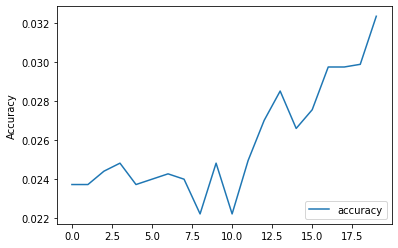

In [36]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
accuracy = np.array(history.history['accuracy'])
np.save('saved_accuracy1', accuracy)
model.save('saved_model1')

/var/folders/ds/wbcxshsj0knblcfvxyjgzn5w0000gq/T/ipykernel_7639/1844858298.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator=DataGenerator(db_dir = "./images", input_shape = (32, 32, 3), num_classes = 37, batch_size=128, shuffle=True), epochs=10, verbose=1)


Epoch 1/10


/Users/gborlea/Documents/gabi/uni/CVDL/Labs/venv/lib/python3.8/site-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


20/57 [=========>....................] - ETA: 38s - loss: 3.5932 - accuracy: 0.0316

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


57/57 [==============================] - 59s 1s/step - loss: 3.5890 - accuracy: 0.0339
Epoch 2/10
34/57 [================>.............] - ETA: 24s - loss: 3.5815 - accuracy: 0.0296

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


39/57 [===================>..........] - ETA: 18s - loss: 3.5793 - accuracy: 0.0310

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


57/57 [==============================] - 61s 1s/step - loss: 3.5782 - accuracy: 0.0330
Epoch 3/10
 7/57 [==>...........................] - ETA: 53s - loss: 3.5633 - accuracy: 0.0502

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


55/57 [===========================>..] - ETA: 2s - loss: 3.5718 - accuracy: 0.0413

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


57/57 [==============================] - 59s 1s/step - loss: 3.5726 - accuracy: 0.0415
Epoch 4/10
 3/57 [>.............................] - ETA: 56s - loss: 3.5652 - accuracy: 0.0417 

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


22/57 [==========>...................] - ETA: 36s - loss: 3.5554 - accuracy: 0.0455

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


57/57 [==============================] - 58s 1s/step - loss: 3.5613 - accuracy: 0.0456
Epoch 5/10
23/57 [===========>..................] - ETA: 35s - loss: 3.5383 - accuracy: 0.0550

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


27/57 [=============>................] - ETA: 31s - loss: 3.5370 - accuracy: 0.0532

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


57/57 [==============================] - 57s 994ms/step - loss: 3.5392 - accuracy: 0.0529
Epoch 6/10
15/57 [======>.......................] - ETA: 40s - loss: 3.5143 - accuracy: 0.0552

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


57/57 [==============================] - 55s 959ms/step - loss: 3.5313 - accuracy: 0.0546
Epoch 7/10


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


43/57 [=====================>........] - ETA: 13s - loss: 3.5085 - accuracy: 0.0658

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


57/57 [==============================] - 55s 967ms/step - loss: 3.5018 - accuracy: 0.0659
Epoch 8/10
32/57 [===============>..............] - ETA: 24s - loss: 3.4697 - accuracy: 0.0745

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


40/57 [====================>.........] - ETA: 16s - loss: 3.4736 - accuracy: 0.0717

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


57/57 [==============================] - 56s 979ms/step - loss: 3.4791 - accuracy: 0.0694
Epoch 9/10
 4/57 [=>............................] - ETA: 56s - loss: 3.4118 - accuracy: 0.0898

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


23/57 [===========>..................] - ETA: 34s - loss: 3.4334 - accuracy: 0.0771

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


57/57 [==============================] - 55s 965ms/step - loss: 3.4433 - accuracy: 0.0781
Epoch 10/10
 2/57 [>.............................] - ETA: 51s - loss: 3.4219 - accuracy: 0.0859

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


46/57 [=======================>......] - ETA: 10s - loss: 3.3961 - accuracy: 0.0873

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


57/57 [==============================] - 56s 985ms/step - loss: 3.3994 - accuracy: 0.0862
INFO:tensorflow:Assets written to: saved_model2/assets


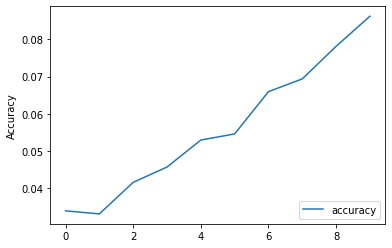

In [37]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(
    loss= SparseCategoricalCrossentropy(from_logits=True),
    optimizer=opt,
    metrics=['accuracy']
)
history = model.fit_generator(generator=DataGenerator(db_dir = "./images", input_shape = (32, 32, 3), num_classes = 37, batch_size=128, shuffle=True), epochs=10, verbose=1)
plt.plot(history.history['accuracy'], label='accuracy')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
accuracy = np.array(history.history['accuracy'])
np.save('saved_accuracy2', accuracy)
model.save('saved_model2')

/var/folders/ds/wbcxshsj0knblcfvxyjgzn5w0000gq/T/ipykernel_7639/2292220324.py:15: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator=DataGenerator(db_dir = "./images", input_shape = (32, 32, 3), num_classes = 37, batch_size=128, shuffle=True), epochs=10, verbose=1)


Epoch 1/10


/Users/gborlea/Documents/gabi/uni/CVDL/Labs/venv/lib/python3.8/site-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


15/57 [======>.......................] - ETA: 43s - loss: 6.7458 - accuracy: 0.0500

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


16/57 [=======>......................] - ETA: 42s - loss: 6.5504 - accuracy: 0.0483

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


46/57 [=======================>......] - ETA: 11s - loss: 4.6193 - accuracy: 0.0419

Corrupt JPEG data: premature end of data segment


47/57 [=======================>......] - ETA: 10s - loss: 4.5982 - accuracy: 0.0416

Corrupt JPEG data: premature end of data segment


57/57 [==============================] - 60s 1s/step - loss: 4.4185 - accuracy: 0.0419
Epoch 2/10
34/57 [================>.............] - ETA: 22s - loss: 3.5534 - accuracy: 0.0496

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


44/57 [======================>.......] - ETA: 12s - loss: 3.5554 - accuracy: 0.0485

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


57/57 [==============================] - 56s 982ms/step - loss: 3.5575 - accuracy: 0.0481
Epoch 3/10
33/57 [================>.............] - ETA: 23s - loss: 3.5497 - accuracy: 0.0476

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


41/57 [====================>.........] - ETA: 15s - loss: 3.5435 - accuracy: 0.0497

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


57/57 [==============================] - 56s 979ms/step - loss: 3.5470 - accuracy: 0.0502
Epoch 4/10
 3/57 [>.............................] - ETA: 52s - loss: 3.5428 - accuracy: 0.0625

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


 6/57 [==>...........................] - ETA: 48s - loss: 3.5474 - accuracy: 0.0573

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


57/57 [==============================] - 56s 984ms/step - loss: 3.5402 - accuracy: 0.0521
Epoch 5/10
40/57 [====================>.........] - ETA: 17s - loss: 3.5382 - accuracy: 0.0557

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


48/57 [========================>.....] - ETA: 9s - loss: 3.5360 - accuracy: 0.0542 

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


57/57 [==============================] - 60s 1s/step - loss: 3.5350 - accuracy: 0.0537
Epoch 6/10
13/57 [=====>........................] - ETA: 47s - loss: 3.5441 - accuracy: 0.0505

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


51/57 [=========================>....] - ETA: 6s - loss: 3.5327 - accuracy: 0.0544

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


57/57 [==============================] - 62s 1s/step - loss: 3.5304 - accuracy: 0.0554
Epoch 7/10
 4/57 [=>............................] - ETA: 57s - loss: 3.5419 - accuracy: 0.0488

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


16/57 [=======>......................] - ETA: 41s - loss: 3.5254 - accuracy: 0.0566

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


57/57 [==============================] - 57s 1s/step - loss: 3.5259 - accuracy: 0.0562
Epoch 8/10
45/57 [======================>.......] - ETA: 11s - loss: 3.5238 - accuracy: 0.0545

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


57/57 [==============================] - 54s 945ms/step - loss: 3.5213 - accuracy: 0.0569
Epoch 9/10
19/57 [=========>....................] - ETA: 35s - loss: 3.5263 - accuracy: 0.0551

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


42/57 [=====================>........] - ETA: 14s - loss: 3.5240 - accuracy: 0.0541

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


57/57 [==============================] - 55s 967ms/step - loss: 3.5183 - accuracy: 0.0570
Epoch 10/10
41/57 [====================>.........] - ETA: 15s - loss: 3.5165 - accuracy: 0.0574

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


49/57 [========================>.....] - ETA: 7s - loss: 3.5154 - accuracy: 0.0582

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


57/57 [==============================] - 57s 990ms/step - loss: 3.5156 - accuracy: 0.0578
INFO:tensorflow:Assets written to: saved_model3/assets


NotImplementedError: Learning rate schedule must override get_config

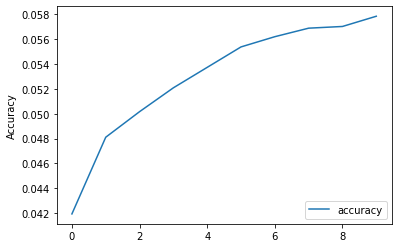

In [38]:
class MyLRSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, initial_learning_rate):
    self.initial_learning_rate = initial_learning_rate

  def __call__(self, step):
     return self.initial_learning_rate / (step + 1)

opt = tf.keras.optimizers.Adam(learning_rate=MyLRSchedule(0.01))
model.compile(
    loss= SparseCategoricalCrossentropy(from_logits=True),
    optimizer=opt,
    metrics=['accuracy']
)
history = model.fit_generator(generator=DataGenerator(db_dir = "./images", input_shape = (32, 32, 3), num_classes = 37, batch_size=128, shuffle=True), epochs=10, verbose=1)
plt.plot(history.history['accuracy'], label='accuracy')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
accuracy = np.array(history.history['accuracy'])
np.save('saved_accuracy3', accuracy)
model.save('saved_model3')




/var/folders/ds/wbcxshsj0knblcfvxyjgzn5w0000gq/T/ipykernel_7639/359763328.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator=DataGenerator(db_dir = "./images", input_shape = (32, 32, 3), num_classes = 37, batch_size=128, shuffle=True), epochs=10, verbose=1)


Epoch 1/10


/Users/gborlea/Documents/gabi/uni/CVDL/Labs/venv/lib/python3.8/site-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


17/57 [=======>......................] - ETA: 43s - loss: 3.6115 - accuracy: 0.0267

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


53/57 [==========================>...] - ETA: 4s - loss: 3.6133 - accuracy: 0.0248

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


57/57 [==============================] - 63s 1s/step - loss: 3.6133 - accuracy: 0.0244
Epoch 2/10
 3/57 [>.............................] - ETA: 56s - loss: 3.6109 - accuracy: 0.0339

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


29/57 [==============>...............] - ETA: 30s - loss: 3.6114 - accuracy: 0.0280

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


57/57 [==============================] - 62s 1s/step - loss: 3.6126 - accuracy: 0.0248
Epoch 3/10
 6/57 [==>...........................] - ETA: 54s - loss: 3.6112 - accuracy: 0.0156

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


57/57 [==============================] - 62s 1s/step - loss: 3.6123 - accuracy: 0.0225
Epoch 4/10
14/57 [======>.......................] - ETA: 46s - loss: 3.6113 - accuracy: 0.0318

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


46/57 [=======================>......] - ETA: 12s - loss: 3.6124 - accuracy: 0.0245

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


57/57 [==============================] - 64s 1s/step - loss: 3.6127 - accuracy: 0.0240
Epoch 5/10
 7/57 [==>...........................] - ETA: 52s - loss: 3.6117 - accuracy: 0.0257

Corrupt JPEG data: premature end of data segment


 8/57 [===>..........................] - ETA: 51s - loss: 3.6115 - accuracy: 0.0254

Corrupt JPEG data: premature end of data segment


25/57 [============>.................] - ETA: 34s - loss: 3.6112 - accuracy: 0.0306

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


26/57 [============>.................] - ETA: 33s - loss: 3.6112 - accuracy: 0.0306

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


57/57 [==============================] - 64s 1s/step - loss: 3.6129 - accuracy: 0.0256
Epoch 6/10
53/57 [==========================>...] - ETA: 4s - loss: 3.6127 - accuracy: 0.0242

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


55/57 [===========================>..] - ETA: 2s - loss: 3.6127 - accuracy: 0.0239

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


57/57 [==============================] - 66s 1s/step - loss: 3.6127 - accuracy: 0.0241
Epoch 7/10
25/57 [============>.................] - ETA: 36s - loss: 3.6108 - accuracy: 0.0312

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


30/57 [==============>...............] - ETA: 30s - loss: 3.6111 - accuracy: 0.0302

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


57/57 [==============================] - 65s 1s/step - loss: 3.6128 - accuracy: 0.0256
Epoch 8/10
27/57 [=============>................] - ETA: 40s - loss: 3.6116 - accuracy: 0.0252

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


51/57 [=========================>....] - ETA: 9s - loss: 3.6123 - accuracy: 0.0234 

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


57/57 [==============================] - 89s 2s/step - loss: 3.6125 - accuracy: 0.0229
Epoch 9/10
31/57 [===============>..............] - ETA: 33s - loss: 3.6117 - accuracy: 0.0295

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


46/57 [=======================>......] - ETA: 13s - loss: 3.6121 - accuracy: 0.0272

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


57/57 [==============================] - 71s 1s/step - loss: 3.6123 - accuracy: 0.0267
Epoch 10/10
30/57 [==============>...............] - ETA: 33s - loss: 3.6113 - accuracy: 0.0234

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


53/57 [==========================>...] - ETA: 4s - loss: 3.6122 - accuracy: 0.0221

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


57/57 [==============================] - 66s 1s/step - loss: 3.6125 - accuracy: 0.0214
INFO:tensorflow:Assets written to: saved_model7/assets


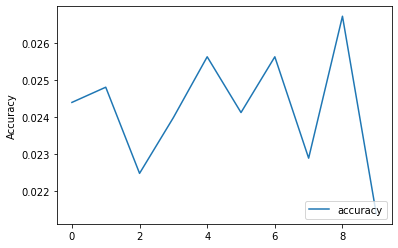

In [43]:
opt = tf.keras.optimizers.Adam(learning_rate=0.01)
model.compile(
    loss= SparseCategoricalCrossentropy(from_logits=True),
    optimizer=opt,
    metrics=['accuracy']
)
history = model.fit_generator(generator=DataGenerator(db_dir = "./images", input_shape = (32, 32, 3), num_classes = 37, batch_size=128, shuffle=True), epochs=10, verbose=1)
plt.plot(history.history['accuracy'], label='accuracy')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
accuracy = np.array(history.history['accuracy'])
np.save('saved_accuracy7', accuracy)
model.save('saved_model7')

/var/folders/ds/wbcxshsj0knblcfvxyjgzn5w0000gq/T/ipykernel_7639/3070761061.py:11: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator=DataGenerator(db_dir = "./images", input_shape = (32, 32, 3), num_classes = 37, batch_size=128, shuffle=True), epochs=10, verbose=1)


Epoch 1/10


/Users/gborlea/Documents/gabi/uni/CVDL/Labs/venv/lib/python3.8/site-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


 3/57 [>.............................] - ETA: 56s - loss: 4.9891 - accuracy: 0.0495

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


 6/57 [==>...........................] - ETA: 51s - loss: 4.3755 - accuracy: 0.0443

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


57/57 [==============================] - 61s 1s/step - loss: 3.7038 - accuracy: 0.0296
Epoch 2/10
26/57 [============>.................] - ETA: 31s - loss: 3.6143 - accuracy: 0.0264

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


40/57 [====================>.........] - ETA: 17s - loss: 3.6137 - accuracy: 0.0256

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


57/57 [==============================] - 59s 1s/step - loss: 3.6154 - accuracy: 0.0241
Epoch 3/10
11/57 [====>.........................] - ETA: 50s - loss: 3.6113 - accuracy: 0.0234

Corrupt JPEG data: premature end of data segment


12/57 [=====>........................] - ETA: 49s - loss: 3.6113 - accuracy: 0.0234

Corrupt JPEG data: premature end of data segment


54/57 [===========================>..] - ETA: 3s - loss: 3.6127 - accuracy: 0.0237

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


57/57 [==============================] - 62s 1s/step - loss: 3.6127 - accuracy: 0.0233
Epoch 4/10
 9/57 [===>..........................] - ETA: 50s - loss: 3.6204 - accuracy: 0.0330

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


29/57 [==============>...............] - ETA: 29s - loss: 3.6141 - accuracy: 0.0280

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


57/57 [==============================] - 59s 1s/step - loss: 3.6165 - accuracy: 0.0256
Epoch 5/10


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


23/57 [===========>..................] - ETA: 33s - loss: 3.6225 - accuracy: 0.0302

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


57/57 [==============================] - 56s 981ms/step - loss: 3.6198 - accuracy: 0.0266
Epoch 6/10
 5/57 [=>............................] - ETA: 47s - loss: 3.6113 - accuracy: 0.0312

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


35/57 [=================>............] - ETA: 20s - loss: 3.6117 - accuracy: 0.0257

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


57/57 [==============================] - 55s 956ms/step - loss: 3.6365 - accuracy: 0.0247
Epoch 7/10


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


55/57 [===========================>..] - ETA: 2s - loss: 3.6129 - accuracy: 0.0239

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


57/57 [==============================] - 57s 1s/step - loss: 3.6130 - accuracy: 0.0234
Epoch 8/10
 9/57 [===>..........................] - ETA: 48s - loss: 3.6108 - accuracy: 0.0217

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


44/57 [======================>.......] - ETA: 13s - loss: 3.6120 - accuracy: 0.0233

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


57/57 [==============================] - 59s 1s/step - loss: 3.6125 - accuracy: 0.0217
Epoch 9/10


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


43/57 [=====================>........] - ETA: 15s - loss: 3.6117 - accuracy: 0.0280

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


57/57 [==============================] - 62s 1s/step - loss: 3.6124 - accuracy: 0.0260
Epoch 10/10
19/57 [=========>....................] - ETA: 41s - loss: 3.6106 - accuracy: 0.0333

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


22/57 [==========>...................] - ETA: 38s - loss: 3.6109 - accuracy: 0.0320

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


23/57 [===========>..................] - ETA: 37s - loss: 3.6110 - accuracy: 0.0312

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


57/57 [==============================] - 60s 1s/step - loss: 3.6127 - accuracy: 0.0255
INFO:tensorflow:Assets written to: saved_model4/assets


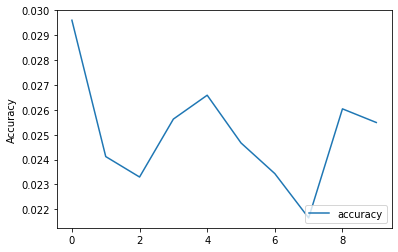

In [40]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.5)
opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
model.compile(
    loss= SparseCategoricalCrossentropy(from_logits=True),
    optimizer=opt,
    metrics=['accuracy']
)
history = model.fit_generator(generator=DataGenerator(db_dir = "./images", input_shape = (32, 32, 3), num_classes = 37, batch_size=128, shuffle=True), epochs=10, verbose=1)
plt.plot(history.history['accuracy'], label='accuracy')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
accuracy = np.array(history.history['accuracy'])
np.save('saved_accuracy4', accuracy)
model.save('saved_model4')

/var/folders/ds/wbcxshsj0knblcfvxyjgzn5w0000gq/T/ipykernel_7639/200404990.py:10: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator=DataGenerator(db_dir = "./images", input_shape = (32, 32, 3), num_classes = 37, batch_size=128, shuffle=True), epochs=10, verbose=1)


Epoch 1/10


/Users/gborlea/Documents/gabi/uni/CVDL/Labs/venv/lib/python3.8/site-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


24/57 [===========>..................] - ETA: 44s - loss: 3.6269 - accuracy: 0.0277

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


38/57 [===================>..........] - ETA: 29s - loss: 3.6293 - accuracy: 0.0261

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


57/57 [==============================] - 83s 1s/step - loss: 3.6292 - accuracy: 0.0262
Epoch 2/10
28/57 [=============>................] - ETA: 34s - loss: 3.6261 - accuracy: 0.0290

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


42/57 [=====================>........] - ETA: 17s - loss: 3.6262 - accuracy: 0.0285

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


57/57 [==============================] - 68s 1s/step - loss: 3.6257 - accuracy: 0.0281
Epoch 3/10
12/57 [=====>........................] - ETA: 50s - loss: 3.6254 - accuracy: 0.0273

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


13/57 [=====>........................] - ETA: 49s - loss: 3.6252 - accuracy: 0.0264

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


43/57 [=====================>........] - ETA: 15s - loss: 3.6240 - accuracy: 0.0274

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


57/57 [==============================] - 62s 1s/step - loss: 3.6233 - accuracy: 0.0262
Epoch 4/10
 6/57 [==>...........................] - ETA: 53s - loss: 3.6186 - accuracy: 0.0312

Corrupt JPEG data: premature end of data segment


 7/57 [==>...........................] - ETA: 51s - loss: 3.6198 - accuracy: 0.0312

Corrupt JPEG data: premature end of data segment


34/57 [================>.............] - ETA: 23s - loss: 3.6216 - accuracy: 0.0250

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


57/57 [==============================] - 58s 1s/step - loss: 3.6228 - accuracy: 0.0251
Epoch 5/10
16/57 [=======>......................] - ETA: 40s - loss: 3.6254 - accuracy: 0.0254

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


33/57 [================>.............] - ETA: 24s - loss: 3.6255 - accuracy: 0.0232

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


57/57 [==============================] - 60s 1s/step - loss: 3.6247 - accuracy: 0.0238
Epoch 6/10
15/57 [======>.......................] - ETA: 45s - loss: 3.6186 - accuracy: 0.0260

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


30/57 [==============>...............] - ETA: 28s - loss: 3.6215 - accuracy: 0.0284

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


57/57 [==============================] - 60s 1s/step - loss: 3.6237 - accuracy: 0.0241
Epoch 7/10
23/57 [===========>..................] - ETA: 34s - loss: 3.6179 - accuracy: 0.0221

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


31/57 [===============>..............] - ETA: 26s - loss: 3.6189 - accuracy: 0.0222

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


57/57 [==============================] - 56s 979ms/step - loss: 3.6219 - accuracy: 0.0234
Epoch 8/10
20/57 [=========>....................] - ETA: 35s - loss: 3.6184 - accuracy: 0.0227

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


31/57 [===============>..............] - ETA: 24s - loss: 3.6186 - accuracy: 0.0232

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


57/57 [==============================] - 54s 949ms/step - loss: 3.6210 - accuracy: 0.0244
Epoch 9/10
 4/57 [=>............................] - ETA: 52s - loss: 3.6140 - accuracy: 0.0254

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


35/57 [=================>............] - ETA: 20s - loss: 3.6213 - accuracy: 0.0248

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


57/57 [==============================] - 54s 937ms/step - loss: 3.6209 - accuracy: 0.0243
Epoch 10/10
 9/57 [===>..........................] - ETA: 45s - loss: 3.6141 - accuracy: 0.0304

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


12/57 [=====>........................] - ETA: 42s - loss: 3.6152 - accuracy: 0.0306

Corrupt JPEG data: premature end of data segment


13/57 [=====>........................] - ETA: 41s - loss: 3.6158 - accuracy: 0.0300

Corrupt JPEG data: premature end of data segment


57/57 [==============================] - 55s 960ms/step - loss: 3.6186 - accuracy: 0.0243
INFO:tensorflow:Assets written to: saved_model5/assets


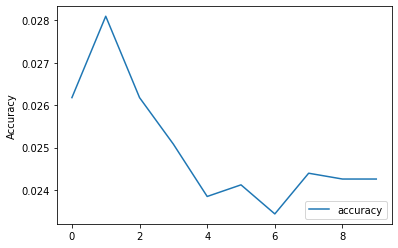

In [41]:
lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=0.1,
    decay_steps=1000,)
opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
model.compile(
    loss= SparseCategoricalCrossentropy(from_logits=True),
    optimizer=opt,
    metrics=['accuracy']
)
history = model.fit_generator(generator=DataGenerator(db_dir = "./images", input_shape = (32, 32, 3), num_classes = 37, batch_size=128, shuffle=True), epochs=10, verbose=1)
plt.plot(history.history['accuracy'], label='accuracy')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
accuracy = np.array(history.history['accuracy'])
np.save('saved_accuracy5', accuracy)
model.save('saved_model5')

/var/folders/ds/wbcxshsj0knblcfvxyjgzn5w0000gq/T/ipykernel_7639/2145731665.py:11: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator=DataGenerator(db_dir = "./images", input_shape = (32, 32, 3), num_classes = 37, batch_size=128, shuffle=True), epochs=10, verbose=1)


Epoch 1/10


/Users/gborlea/Documents/gabi/uni/CVDL/Labs/venv/lib/python3.8/site-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


11/57 [====>.........................] - ETA: 46s - loss: 3.6238 - accuracy: 0.0291

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


23/57 [===========>..................] - ETA: 35s - loss: 3.6203 - accuracy: 0.0302

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


57/57 [==============================] - 58s 1s/step - loss: 3.6215 - accuracy: 0.0260
Epoch 2/10
36/57 [=================>............] - ETA: 21s - loss: 3.6143 - accuracy: 0.0276

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


45/57 [======================>.......] - ETA: 12s - loss: 3.6143 - accuracy: 0.0271

Corrupt JPEG data: premature end of data segment


46/57 [=======================>......] - ETA: 11s - loss: 3.6144 - accuracy: 0.0268

Corrupt JPEG data: premature end of data segment


57/57 [==============================] - 58s 1s/step - loss: 3.6137 - accuracy: 0.0274
Epoch 3/10
31/57 [===============>..............] - ETA: 28s - loss: 3.6116 - accuracy: 0.0270

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


45/57 [======================>.......] - ETA: 12s - loss: 3.6120 - accuracy: 0.0255

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


57/57 [==============================] - 61s 1s/step - loss: 3.6126 - accuracy: 0.0273
Epoch 4/10
13/57 [=====>........................] - ETA: 42s - loss: 3.6129 - accuracy: 0.0258

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


52/57 [==========================>...] - ETA: 4s - loss: 3.6124 - accuracy: 0.0276

Corrupt JPEG data: premature end of data segment


53/57 [==========================>...] - ETA: 3s - loss: 3.6123 - accuracy: 0.0277

Corrupt JPEG data: premature end of data segment


57/57 [==============================] - 57s 991ms/step - loss: 3.6122 - accuracy: 0.0274
Epoch 5/10
19/57 [=========>....................] - ETA: 36s - loss: 3.6128 - accuracy: 0.0259

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


28/57 [=============>................] - ETA: 27s - loss: 3.6120 - accuracy: 0.0262

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


57/57 [==============================] - 56s 977ms/step - loss: 3.6119 - accuracy: 0.0271
Epoch 6/10
 3/57 [>.............................] - ETA: 51s - loss: 3.6087 - accuracy: 0.0208

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


20/57 [=========>....................] - ETA: 37s - loss: 3.6114 - accuracy: 0.0266

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


57/57 [==============================] - 57s 990ms/step - loss: 3.6118 - accuracy: 0.0273
Epoch 7/10
 9/57 [===>..........................] - ETA: 47s - loss: 3.6132 - accuracy: 0.0260

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


54/57 [===========================>..] - ETA: 2s - loss: 3.6116 - accuracy: 0.0271

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


57/57 [==============================] - 56s 985ms/step - loss: 3.6116 - accuracy: 0.0269
Epoch 8/10
 2/57 [>.............................] - ETA: 56s - loss: 3.6121 - accuracy: 0.0234 

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


45/57 [======================>.......] - ETA: 11s - loss: 3.6115 - accuracy: 0.0273

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


57/57 [==============================] - 55s 967ms/step - loss: 3.6115 - accuracy: 0.0274
Epoch 9/10
16/57 [=======>......................] - ETA: 39s - loss: 3.6133 - accuracy: 0.0278

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


25/57 [============>.................] - ETA: 31s - loss: 3.6129 - accuracy: 0.0262

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


57/57 [==============================] - 55s 972ms/step - loss: 3.6114 - accuracy: 0.0274
Epoch 10/10
44/57 [======================>.......] - ETA: 12s - loss: 3.6114 - accuracy: 0.0284

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


54/57 [===========================>..] - ETA: 3s - loss: 3.6115 - accuracy: 0.0276

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


57/57 [==============================] - 57s 1s/step - loss: 3.6114 - accuracy: 0.0273
INFO:tensorflow:Assets written to: saved_model6/assets


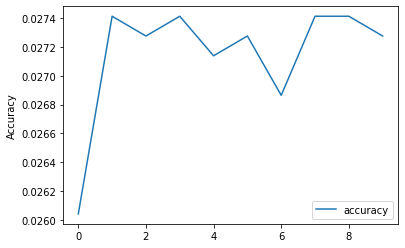

In [42]:
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    initial_learning_rate=0.1,
    decay_steps=1.0,
    decay_rate=0.5)
opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
model.compile(
    loss= SparseCategoricalCrossentropy(from_logits=True),
    optimizer=opt,
    metrics=['accuracy']
)
history = model.fit_generator(generator=DataGenerator(db_dir = "./images", input_shape = (32, 32, 3), num_classes = 37, batch_size=128, shuffle=True), epochs=10, verbose=1)
plt.plot(history.history['accuracy'], label='accuracy')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
accuracy = np.array(history.history['accuracy'])
np.save('saved_accuracy6', accuracy)
model.save('saved_model6')

### **Extra credit**

Implement the learning rate scheduler described in the [paper](!https://arxiv.org/pdf/1608.03983.pdf) "SGDR: Stochastic gradient descent with warm restarts". You are mostly interested in Section 3 from the paper.

In [ ]:
# TODO optional extra credit assignment

## Ensembles
 
Pick your N (3 or 5) of the networks that you've trained and create an ensemble. The prediction of the ensemble is just the average of the predictions of the N networks.
 
Evaluate the ensemble (your accuracy should boost by at least 1.5%).


In [44]:
# TODO your code here
# feed the images to the three networks, average the logits of the networks and 

# evaluate the ensemble
def predict_ensemble(models, X):
    predictions = [models[0].predict(X)]
    for model in models[1:]:
        predictions.append(model.predict(X))

    
    predictions = np.array(predictions)
    avg = np.average(predictions, axis=0)
    return np.argmax(avg, axis=1)

In [46]:
model1 = tf.keras.models.load_model('saved_model1')
model2 = tf.keras.models.load_model('saved_model2')
model3 = tf.keras.models.load_model('saved_model4')

In [55]:
ensemble = [model1, model2, model3]
prediction = predict_ensemble(ensemble, batch_x[:3,:,:,:])
print(prediction)

[22 16  8]


# Transfer learning and fine-tuning
 
In the _tensorflow.keras.applications_ module you can find implementations of several well known CNN architectures (most of the models that we covered during the lecture), as well as the pretrained weights of these models on the ImageNet dataset. 
You can use this module to apply transfer learning and fine-tuning for your classification problem. [Here](!https://keras.io/api/applications/) you can find a comprehensive table with the size of the models, number of parameters, top-1 and top-5 accuracy on the ImageNet dataset.
 
When using deep neural networks, transfer learning is the norm, not the exception.  Transfer learning refers to the situation where what has been learned in one setting is used to improve generalization in another setting.
The transfer learning pipeline can be summarized as follows:
- get the weights of a model trained on similar classification problem (for which more training data is available);
- remove the final classification layer;
- freeze the weights (don't update them during the training process); these layers would be used as a feature extractor;
- add a/some trainable layers over the frozen layers. They will learn how the extracted features can be used to distinguish between the classes of your classification problem.
- train these new layers on your dataset.
 
Next, you can also use fine-tuning. During fine-tuning you will unfreeze the model (or a larger part of the model), and train it on the new data with a very low learning rate.
 
Follow this [tutorial](!https://keras.io/guides/transfer_learning/) to solve this exercise.
 
When following the tutorial
- pay attention to the discussion about the BatchNormalization layers;
- you can skip the section "Transfer learning & fine-tuning with a custom training loop", we'll cover this in the next laboratory;
- pay attention to the loss that you will be using when training your model. In the tutorial the loss is the binary cross entropy loss which is suitable for binary classification problems. If your problem is multi-class you should use the categorical cross entropy loss.
- use the pre-processing required by the network architecture that you chose.
 
To sum up, pick a neural network architecture from the _tensorflow.keras.applications_ module and use transfer learning and fine tuning to train it to classify the images from your dataset (you should use the custom DataGenerator that you wrote for this). 
 Briefly describe the key features of the neural network architecture that you chose and why you chose it.
 
Apply transfer learning (with at least one config for the hyperparameters) and report the performance. Apply fine-tuning  (with at least one config for the hyperparameters) and report the performance.
Finally, plot the performance of the model when you used only transfer learning and the performance of the model when you also used fine-tuning on the same plot.
 
I chose the architecture <font color='red'> TODO </font> , because <font color='red'> TODO </font> .
The key features of this architecture are
- <font color='red'> TODO  </font> 
- <font color='red'> TODO  </font> 
- <font color='red'> TODO  </font> 
 
How does the performance of this fine-tuned model compare to the performance of the network that you trained from scratch?
 




In [67]:
# TODO your transfer-learning and fine-tuning step
import ssl

ssl._create_default_https_context = ssl._create_unverified_context

mobile_model = tf.keras.applications.MobileNetV2(
    input_shape=(32, 32, 3),
    include_top=False,
    weights="imagenet",
)

mobile_model.get_layer()

mobile_model.summary()


Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 Conv1 (Conv2D)                 (None, 16, 16, 32)   864         ['input_4[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 16, 16, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 16, 16, 32)   0           ['bn_Conv1[0][0]']               
                                                                               

In [78]:
out = mobile_model.get_layer('block_5_project')
non_trainable = tf.keras.Model(inputs=mobile_model.input, outputs=out.output)
non_trainable.trainable = False
x = non_trainable(inputs)
x = tf.keras.layers.Conv2D(128, (2, 2), padding='valid', strides=(2, 2), activation='relu', kernel_initializer=he_normal())(x)
x = tf.keras.layers.Conv2D(37, (1, 1), padding='same', activation='relu', kernel_initializer=he_normal())(x)
x = GlobalAveragePooling2D()(x)
outputs = Dense(37, activation=softmax)(x)

In [79]:
model_tranfer_learning = tf.keras.Model(inputs=inputs, outputs=outputs)
model_tranfer_learning.summary()

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 model_11 (Functional)       (None, 4, 4, 32)          58880     
                                                                 
 conv2d_9 (Conv2D)           (None, 2, 2, 128)         16512     
                                                                 
 conv2d_10 (Conv2D)          (None, 2, 2, 37)          4773      
                                                                 
 global_average_pooling2d_1   (None, 37)               0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_1 (Dense)             (None, 37)                1406      
                                                          